<h1>Time Series Profiling</h1>

<h2 align="center">Data Stationarity</h2>

<h3>Seasonality</h3>

In [19]:
from pandas import Series
from matplotlib.pyplot import subplots, show, gca
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from dslabs_functions import HEIGHT, set_chart_labels, ts_aggregation_by


def plot_components(
    series: Series,
    title: str = "",
    x_label: str = "time",
    y_label: str = "",
) -> list[Axes]:
    decomposition: DecomposeResult = seasonal_decompose(series, model="add")
    print(decomposition)
    components: dict = {
        "observed": series,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid,
    }
    rows: int = len(components)
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(rows, 1, figsize=(3 * HEIGHT, rows * HEIGHT))
    fig.suptitle(f"{title}")
    i: int = 0
    for key in components:
        set_chart_labels(axs[i], title=key, xlabel=x_label, ylabel=y_label)
        axs[i].plot(components[key])
        i += 1
    return axs, fig

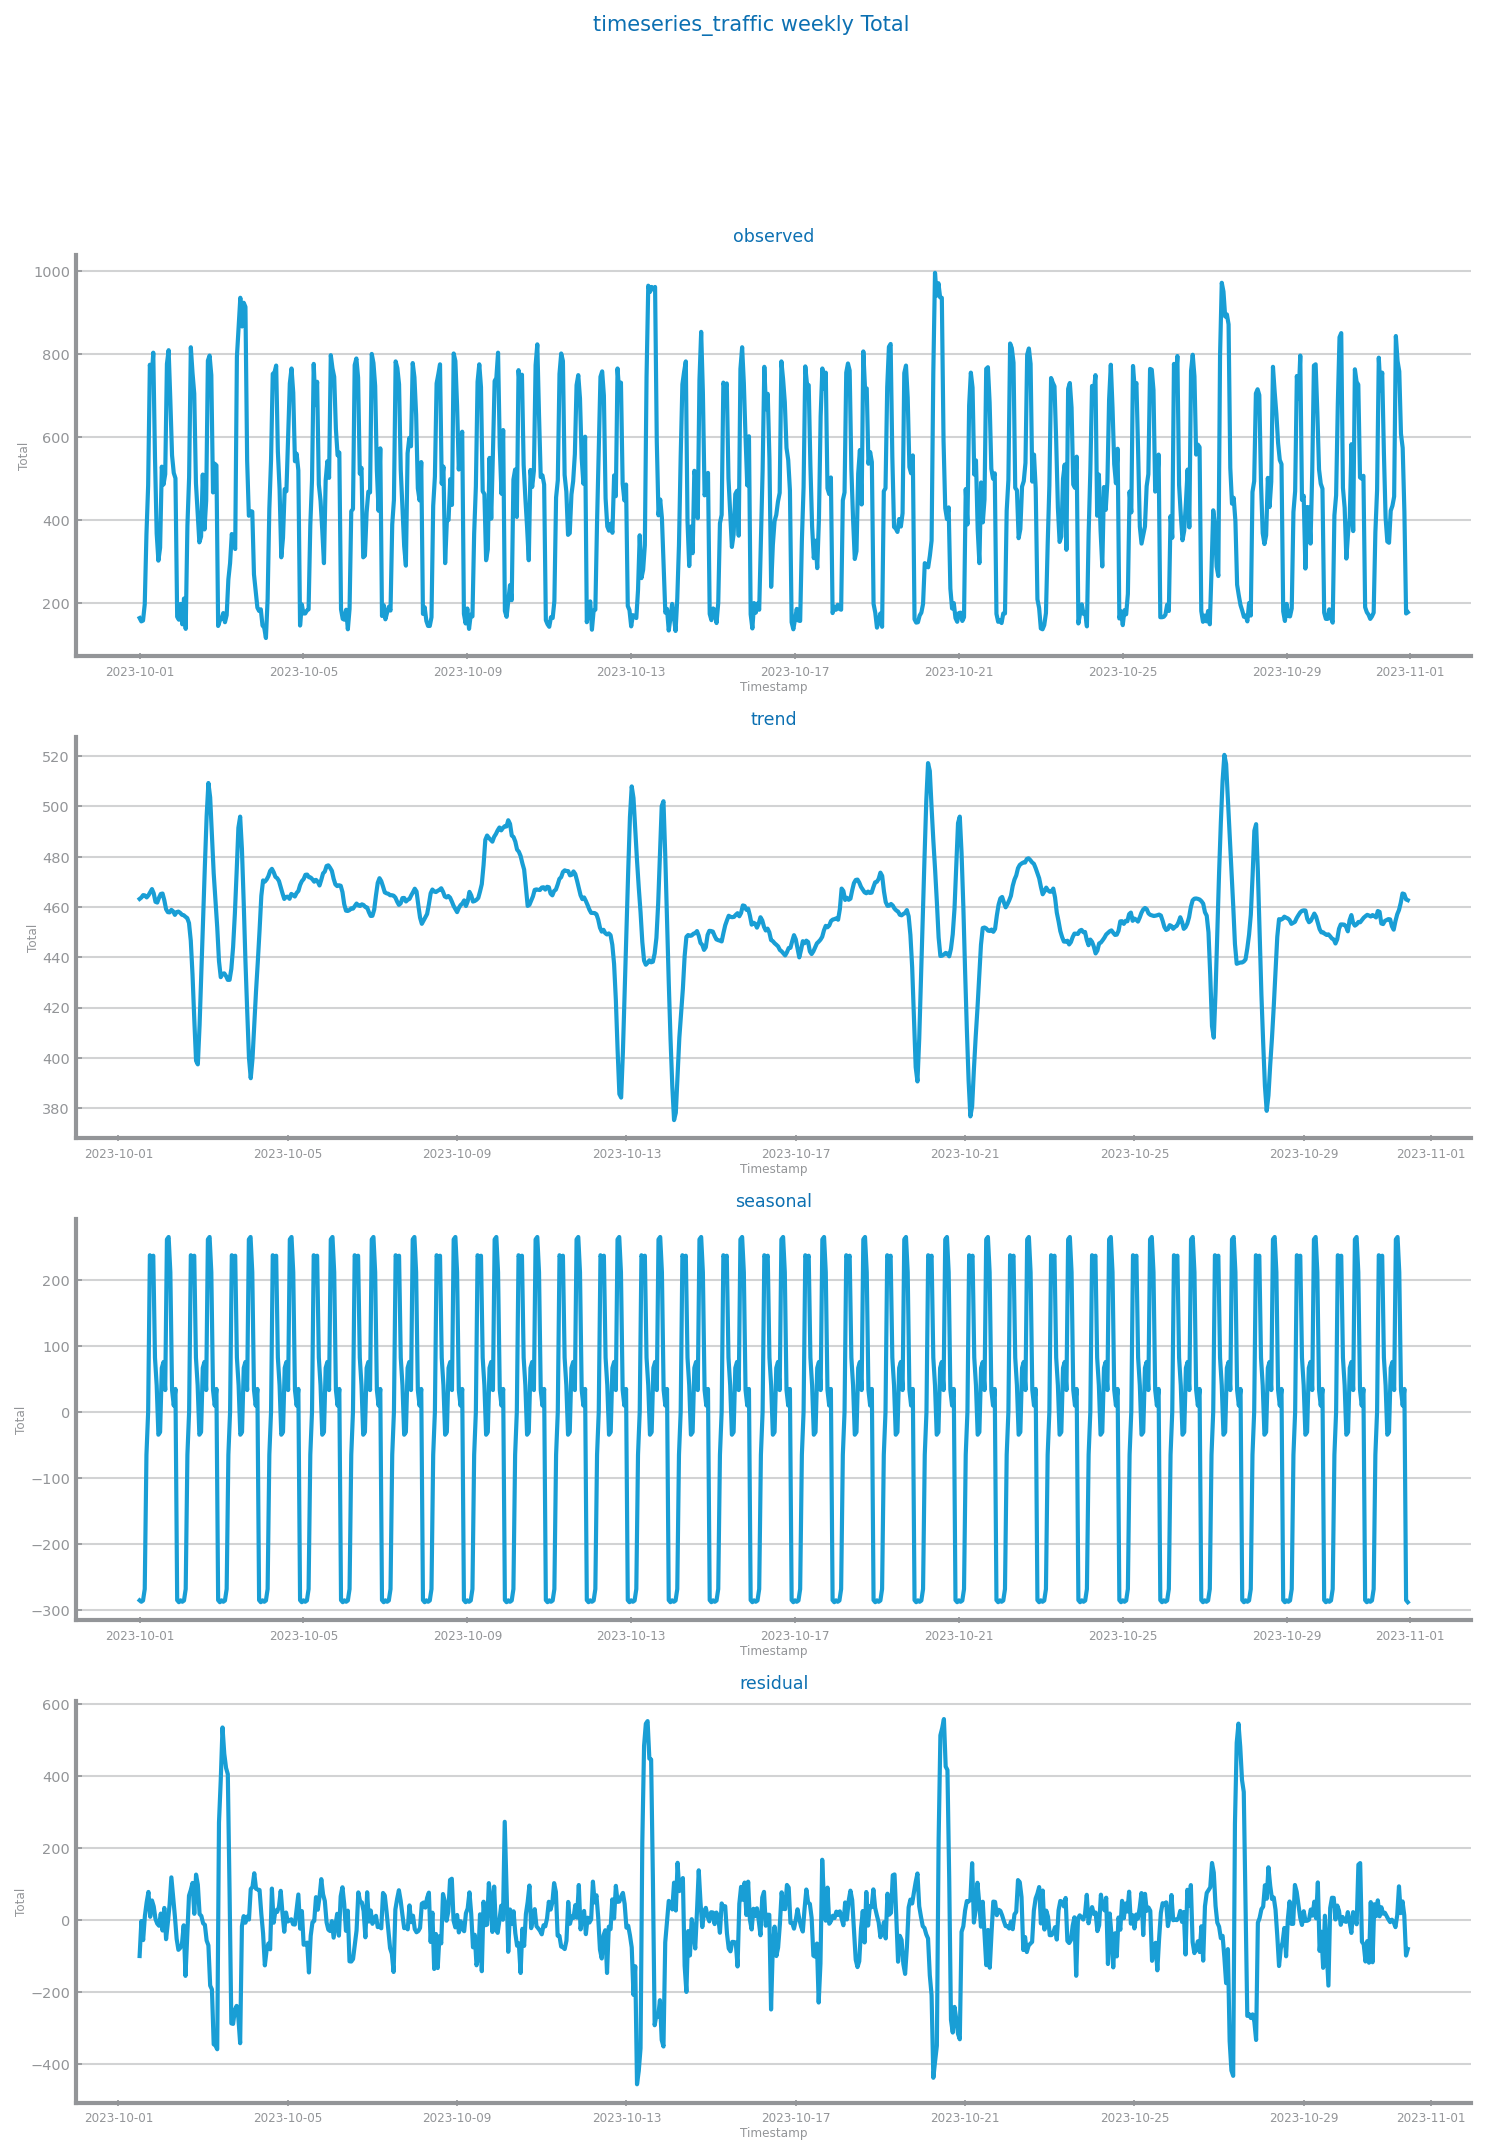

In [20]:
from pandas import DataFrame, Series, read_csv
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart

file_tag = "timeseries_traffic"
target = "Total"
filepath = "../../../data/forecast_traffic_single.csv"
data: DataFrame = read_csv(
    filepath,
    index_col="Timestamp",
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)
series: Series = data[target]
ss_hourly = ts_aggregation_by(series, gran_level="H", agg_func=sum)

axs, fig = plot_components(
    ss_hourly,
    title=f"{file_tag} weekly {target}",
    x_label=ss_hourly.index.name,
    y_label=target,
)
fig.savefig(fname=f"./images/{file_tag}_components.png", bbox_inches="tight")

show()

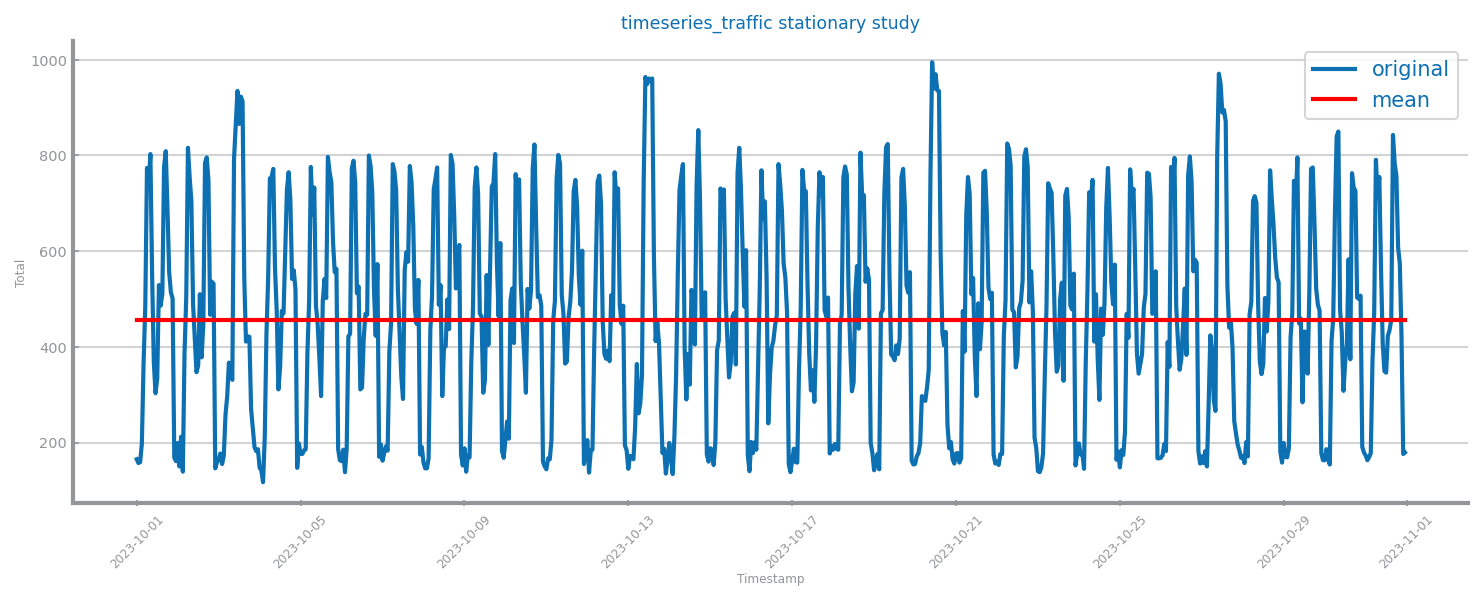

In [24]:
from matplotlib.pyplot import plot, legend

fig = figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_hourly.index.to_list(),
    ss_hourly.to_list(),
    xlabel=ss_hourly.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
)
n: int = len(ss_hourly)
plot(ss_hourly.index, [ss_hourly.mean()] * n, "r-", label="mean")
legend()
fig.savefig(fname=f"./images/{file_tag}_stationary_study_1.png", bbox_inches="tight")

show()

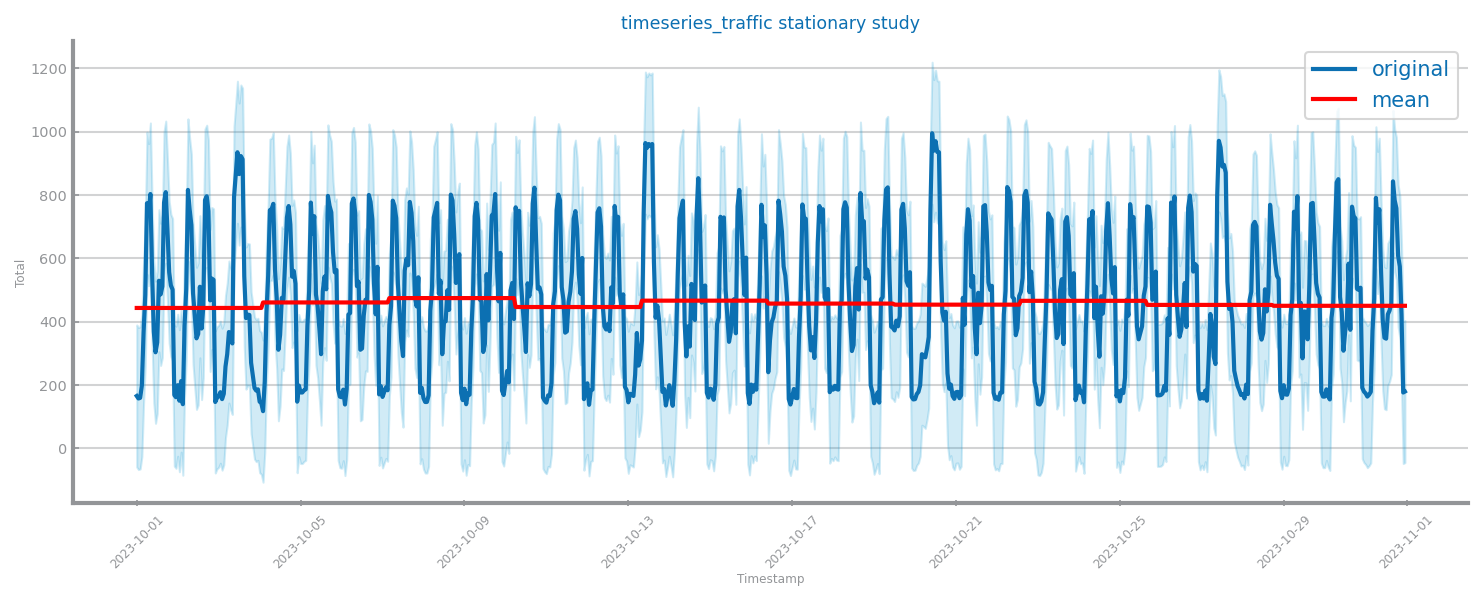

In [25]:
BINS = 10
mean_line: list[float] = []

for i in range(BINS):
    segment: Series = ss_hourly[i * n // BINS : (i + 1) * n // BINS]
    mean_value: list[float] = [segment.mean()] * (n // BINS)
    mean_line += mean_value
mean_line += [mean_line[-1]] * (n - len(mean_line))

fig = figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_hourly.index.to_list(),
    ss_hourly.to_list(),
    xlabel=ss_hourly.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
    show_stdev=True,
)
n: int = len(ss_hourly)
plot(ss_hourly.index, mean_line, "r-", label="mean")
legend()
fig.savefig(fname=f"./images/{file_tag}_stationary_study_2.png", bbox_inches="tight")

show()

<h3>Augmented Dickey-Fuller test</h3>

In [26]:
from statsmodels.tsa.stattools import adfuller


def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05


print(f"The series {('is' if eval_stationarity(ss_hourly) else 'is not')} stationary")

ADF Statistic: -14.169
p-value: 0.000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
The series is stationary
